# Определение оттока клиентов в телеком  
## Задача - построить модель прогнозирующую отток клиента для компании "Ниединогоразрыва.ком".

#### Импортируем необходимые модули

In [460]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import time
import phik

import matplotlib as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
from os import path

from scipy import stats as st
import math as mth
from xgboost import  XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn import set_config
from sklearn.utils import shuffle
from numpy.random import RandomState
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline as sk_Pipeline
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE


from catboost import Pool, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

In [461]:

path_local = '/Users/kbzunder/Downloads/final_provider/'

if path.exists(path_local):
    contracts = pd.read_csv(path_local +'contract.csv')
    internet  = pd.read_csv(path_local + 'internet.csv')
    personal = pd.read_csv(path_local +'personal.csv')
    phone = pd.read_csv(path_local +'phone.csv')
else:
    path_train = '/datasets/final_provider/'
    contracts = pd.read_csv(path_train + 'contracts.csv')
    internet =  pd.read_csv(path_train + 'internet.csv')
    personal = pd.read_csv(path_train + 'personal.csv')
    phone = pd.read_csv(path_train + 'phone.csv')


In [462]:
contracts.head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.650,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.100,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.750,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.800,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.150,3487.95


In [463]:
contracts[contracts['EndDate'] == 'No']['EndDate'].count()

5174

In [464]:
contracts.duplicated().sum()

0

In [465]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [466]:
fig = px.histogram(contracts, x='MonthlyCharges') 
fig.show()

In [467]:
contracts.describe()

,MonthlyCharges
count,7043.000
mean,64.762
std,30.090
min,18.250
25%,35.500
50%,70.350
75%,89.850
max,118.750


#### Целевой признак в задаче - расторжение или сохранение контракта ('EndDate' == 'No'), в нашем датасете из 7043 клиентов 5174 или 73 процента прододжают быть клиентами компании - данные несбалансированы, придется учитывать этот моменет при подготовке признаков.    

In [468]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [469]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [470]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [471]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [472]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [374]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### Первое впечатление от данных  
1. Данные в 4 датасетах, в каждом из которых отсутствуют пропуски  
2. В каждом датасете разное количество наблюдений  
3. Только стобцы `MonthlyCharges` , `TotalCharges` содержат числовую информацию о  выручке с клиента 
4. Данные необходимо объединить в один датафрейм по ключу  `customerID`  

### Метрика качества проекта - ROC-AUC (устойчива к выбросам), дополнительно будем включать в расчеты F1 score и accuracy.

### План работы над проектом  
1. Загрузка, обработка, изучение данных:
    * Загрузка данных. Предобработка: переименование столбцов, проверка типов данных  и замена типов данных (`TofalCharges` бросается в глаза, замена строковых типов дат на дату)
    * Объединение 4 датасетов в один, буду приджойнивать к датасету `contracts` остальные датасеты, содержащие дополнительную информацию  
    * Обработка полученного датасета:
        - Работа с пропусками, возникшими в результате объединения таблиц
        - Создание новых признаков (длительность контракта, пр)
        - Удаление ненужных в построении модели признаков (номер контракта, прочее)
        - Проверка датасета на мультиколлинеарность, удаление столбцов с высокой корреляцией
        - Анализ данных на выбросы, обработка выбросов
2. Подготовка данных к моделированию:
    * Разбиение датасета на тренировочную и тестовую выборки в отношении 75:25  
    * Нормирование данных, при необходимости устранение дисбаланса классов на тренировочной выборке

3. Построение pipeline моделей  с настройкой гиперпараметров, кросс-валидацией; обучение моделей с испльзованием GridSerch:
    * Логистическая регрессия
    * Случайный лес
    * Xboost/CatBoost
    * VotingClassifier
4. Выбор лучшей модели и провека качества модели на тестовых данных  
5. Вывод и рекомендации по модели  





### Вопросов на этом этапе проекта нет

[1. Загрузка данных](#data_download)  
[2. Знакомство в с данными. Предобработка](#data_preprocessing)  
[3. Объединение данных в один датасет, подготовка данных для обучения](#merging)  
[4. Выбор моделей обучения](#model_celection)  
[5. Проверка модели на тестовой выборке](#model_testing)  
[6. Анализ значимости признаков](#feature_selection)  
[7. Выводы](#Conclusion)  


<a id='data_download'></a>
### 1. Загрузка данных

In [16]:
# 

<a id='data_preprocessing'></a>
### 2. Знакомство в с данными. Предобработка

#### Датасет contracts

In [473]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Переименуем столбцы, изменим тип данных в столбцах `BeginDate`, `EndDate` на дату, в столбце `TotalChanges` - на float64 

In [474]:
contracts_columns = ['customer_id','begin_date', 'end_date','type', 'paperless_billing', 'payment_mode', 'monthly_charges', 'total_charges']

In [475]:
contracts.columns = contracts_columns

In [476]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65


In [477]:
contracts['begin_date'] = pd.to_datetime(contracts['begin_date'])

In [478]:
# Заменим все строковые знаечения 'No' в столбце 'end_data' на дату окончания сбора данных - 1 февраля 2020 года
contracts.loc[contracts['end_date']=='No', 'end_date'] = '2020-02-01'

In [479]:
contracts['end_date'] = pd.to_datetime(contracts['end_date'])

In [480]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


In [481]:
contracts['total_charges'] =  pd.to_numeric(contracts['total_charges'], errors='coerce')

In [482]:
contracts[contracts['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.550,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.250,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.850,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.750,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.050,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.850,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.350,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.000,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.700,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.350,NaN


Пропуски в столбце `total_charges` связаны с тем, что это новые клиенты, только заключившие контракт, не успевшие принести доход, заполним эти пропуски 0

In [483]:
contracts['total_charges'] = contracts['total_charges'].fillna(0)

In [484]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [485]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650


In [486]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [487]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650


In [488]:
# Добавим столбец с длительностью контракта в месяцах
contracts['contract_length_mnths'] = (contracts['end_date'] - contracts['begin_date']).dt.days/ 30

In [489]:
# добавим год начала контракта
contracts['begin_year'] = contracts['begin_date'].dt.year

In [490]:
# добавим месяц начала контракта
contracts['begin_month'] = contracts['begin_date'].dt.month

In [491]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_year,begin_month
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850,1.033,2020,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500,34.533,2017,4
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150,2.033,2019,10
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750,45.700,2016,5
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650,2.033,2019,9


In [492]:
# Добавим целевой столбец 'quit' - являтеся ли пользователь действующим клиентом компании (0) или ушедшим (1):
contracts.loc[contracts['end_date']== np.datetime64('2020-02-01'), 'quit'] = 0

In [493]:
contracts.loc[contracts['end_date'] != np.datetime64('2020-02-01'), 'quit'] = 1

In [494]:
contracts['quit'] = contracts['quit'].astype(int)

In [495]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_year,begin_month,quit
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850,1.033,2020,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500,34.533,2017,4,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150,2.033,2019,10,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750,45.700,2016,5,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650,2.033,2019,9,1


In [404]:
#проверим на дубликаты, и выбросы
contracts.duplicated().sum()

0

In [496]:
fig = px.box(contracts, x = 'total_charges', title='Размах суммарных расходов')

fig.show()

Выбросов нет, большая часть клиентов приносит до 4 тыс рублей, а медианный доход около 1400 руб

In [497]:
fig = px.histogram(contracts, x='contract_length_mnths', color ='quit', title='Распределение длительности контрактов в месяцах')
fig.show()

In [498]:
fig1 = px.histogram(contracts.query('quit==1'), x='contract_length_mnths', title='Распределение ушедших клиентов по длине контракта')
fig2 = px.histogram(contracts.query('quit==0'), x='contract_length_mnths', title = 'Распределение активных клиентов по длине контракта' )
fig1.show()
fig2.show()

Видим, что большинство тех, кто уходит, уходит быстро, через 1-3 месяца, а среди активных клиентов много старожилов, которые в компании более 5 лет 

#### Датасет internet

In [499]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [500]:
inter_columns = ['customer_id', 'internet_service','online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']

In [501]:
internet.columns = inter_columns

In [502]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [503]:
internet.duplicated().sum()

0

In [504]:
internet['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

В датасете `internet` меньше наблюдений, чем в contracts, не все пользовтели имеют контракт с интернет-услугами, в датасете нет пропусков и дубликатов, пользователи почти поровну распределяются по виду интренет услуг (Fiber optic и  DSL)

#### Датасет personal

In [505]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [506]:
person_columns = ['customer_id','gender','senior_citizen','partner','dependants']

In [507]:
personal.columns = person_columns

In [508]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependants      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [509]:
personal.duplicated().sum()

0

In [510]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [511]:
personal['dependants'].value_counts()

No     4933
Yes    2110
Name: dependants, dtype: int64

In [512]:
personal['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

In [513]:
personal['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

Среди клинтов примерно поровну мужчин и женщин, имеющих и не имеющих парнтеров, преобладают свободные от иждевенцев и не пенсионеры  

Количество строк в датасете соответствует `contracts`, нет дубликатов и пропусков

#### Датасет phone

In [514]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [517]:
phone = phone.rename(columns={'customerID':'customer_id','MultipleLines':'multiple_lines'})

In [518]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [519]:
phone.duplicated().sum()

0

In [520]:
phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

В датасете `phone` меньше строк, не на всех пользоателей есть информация по нескольким телефонным лииниям, дубликатов и пропусков нет, примерно половина пользовтелей имеет несколько телефонных линий

<a id='merging'></a>
### 3. Объединение данных в один датасет, подготовка данных для обучения

In [521]:
#Объединим датасеты в один, приджойнив остальные датасеты слева к датасету contracts
merged = contracts\
    .merge(personal, on='customer_id', how='left' )\
    .merge(internet, on='customer_id', how='left')\
    .merge(phone, on='customer_id', how='left')

In [522]:
merged.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_year,...,partner,dependants,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850,1.033,2020,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500,34.533,2017,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150,2.033,2019,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750,45.700,2016,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650,2.033,2019,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [523]:
merged.isna().sum().sort_values(ascending=False)

streaming_movies         1526
streaming_tv             1526
tech_support             1526
device_protection        1526
online_backup            1526
online_security          1526
internet_service         1526
multiple_lines            682
begin_date                  0
dependants                  0
partner                     0
senior_citizen              0
customer_id                 0
quit                        0
begin_month                 0
begin_year                  0
contract_length_mnths       0
total_charges               0
monthly_charges             0
payment_mode                0
paperless_billing           0
type                        0
end_date                    0
gender                      0
dtype: int64

In [524]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            7043 non-null   object        
 1   begin_date             7043 non-null   datetime64[ns]
 2   end_date               7043 non-null   datetime64[ns]
 3   type                   7043 non-null   object        
 4   paperless_billing      7043 non-null   object        
 5   payment_mode           7043 non-null   object        
 6   monthly_charges        7043 non-null   float64       
 7   total_charges          7043 non-null   float64       
 8   contract_length_mnths  7043 non-null   float64       
 9   begin_year             7043 non-null   int64         
 10  begin_month            7043 non-null   int64         
 11  quit                   7043 non-null   int64         
 12  gender                 7043 non-null   object        
 13  sen

Пропуски в итоговом датасете связаны с отсутсвием данных - отсутствием у клиента данных услуг, считаю правильным заполнить их значением 'No'

In [525]:
merged = merged.fillna('No')

In [526]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            7043 non-null   object        
 1   begin_date             7043 non-null   datetime64[ns]
 2   end_date               7043 non-null   datetime64[ns]
 3   type                   7043 non-null   object        
 4   paperless_billing      7043 non-null   object        
 5   payment_mode           7043 non-null   object        
 6   monthly_charges        7043 non-null   float64       
 7   total_charges          7043 non-null   float64       
 8   contract_length_mnths  7043 non-null   float64       
 9   begin_year             7043 non-null   int64         
 10  begin_month            7043 non-null   int64         
 11  quit                   7043 non-null   int64         
 12  gender                 7043 non-null   object        
 13  sen

In [67]:
#Удалим столбцы не нужные для анализа: customer_id, begin_date, end_date

In [527]:
merged = merged.drop(['customer_id', 'begin_date','end_date'], axis=1)

In [528]:

#Проверим корреляюцию признаков
correlation = merged.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'contract_length_mnths', 'begin_year', 'begin_month', 'quit', 'senior_citizen']


In [529]:
correlation[correlation > 0.7].fillna('')

,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_year,begin_month,quit,gender,...,partner,dependants,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
type,1.000,,,,,,,,,,...,,,,,,,,,,
paperless_billing,,1.000,,,,,,,,,...,,,,,,,,,,
payment_mode,,,1.000,,,,,,,,...,,,,,,,,,,
monthly_charges,,,,1.000,0.763,,,,,,...,,,0.919,,,,,0.835,0.833,
total_charges,,,,0.763,1.000,0.842,0.733,,,,...,,,,,,,,,,
contract_length_mnths,,,,,0.842,1.000,0.927,,,,...,,,,,,,,,,
begin_year,,,,,0.733,0.927,1.000,,,,...,,,,,,,,,,
begin_month,,,,,,,,1.000,,,...,,,,,,,,,,
quit,,,,,,,,,1.000,,...,,,,,,,,,,
gender,,,,,,,,,,1.000,...,,,,,,,,,,


In [530]:
# Можно удалить один из двух столбцов, корреляция которых выше 0.7, удалим столбцы 'total_charges', 'streaming_movies', 'streaming_tv', 'contract_length_mnths' ,
# 'internet_service'
merged = merged.drop(columns=['streaming_movies','streaming_tv','total_charges','internet_service','contract_length_mnths'], axis=1)



In [531]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_mode       7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   begin_year         7043 non-null   int64  
 5   begin_month        7043 non-null   int64  
 6   quit               7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependants         7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  multiple_lines     7043 non-null   object 
dtypes: float64(1), int64(4),

In [532]:
features = merged.drop(columns='quit', axis=1)
target = merged['quit']

In [533]:
features.head()

,type,paperless_billing,payment_mode,monthly_charges,begin_year,begin_month,gender,senior_citizen,partner,dependants,online_security,online_backup,device_protection,tech_support,multiple_lines
0,Month-to-month,Yes,Electronic check,29.850,2020,1,Female,0,Yes,No,No,Yes,No,No,No
1,One year,No,Mailed check,56.950,2017,4,Male,0,No,No,Yes,No,Yes,No,No
2,Month-to-month,Yes,Mailed check,53.850,2019,10,Male,0,No,No,Yes,Yes,No,No,No
3,One year,No,Bank transfer (automatic),42.300,2016,5,Male,0,No,No,Yes,No,Yes,Yes,No
4,Month-to-month,Yes,Electronic check,70.700,2019,9,Female,0,No,No,No,No,No,No,No


In [534]:
features = pd.get_dummies(features, drop_first=True)

In [535]:
features.head()

,monthly_charges,begin_year,begin_month,senior_citizen,type_One year,type_Two year,paperless_billing_Yes,payment_mode_Credit card (automatic),payment_mode_Electronic check,payment_mode_Mailed check,gender_Male,partner_Yes,dependants_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,multiple_lines_Yes
0,29.850,2020,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0
1,56.950,2017,4,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0
2,53.850,2019,10,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0
3,42.300,2016,5,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0
4,70.700,2019,9,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [446]:
# Разделим данные на обучающую и тестовую выборку в отношении 75:25
features_train, features_test, target_train, target_test \
    = train_test_split(features, target,  train_size=0.75, random_state=101022, shuffle=target)

In [536]:
(features_train.shape, target_train.shape)

((5282, 24), (5282,))

In [537]:
(features_test.shape, target_test.shape)

((1761, 24), (1761,))

#### Создадим pipeline

In [538]:
state = RandomState(101022)

In [539]:
classifiers = [
  LogisticRegression(random_state=state),
  RandomForestClassifier(random_state=state),
  XGBClassifier(random_state=state),
  AdaBoostClassifier(),
  CatBoostClassifier(eval_metric='AUC')
]

In [540]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [541]:
class_prarms = [
    { 'class__solver' : ['lbfgs', 'liblinear'],'class__penalty' :['l1','l2','none'], 'class__C': np.arange(0.5,1.5,0.25), 'class__fit_intercept' : [True, False] },
    {'class__max_features': ['auto','log2','sqrt', 'None'],'class__criterion' : ['gini', 'log_loss', 'entropy'], 'class__n_estimators' : range(10,1000,10), 'class__max_depth' : range(1,50), 'class__min_samples_split': range(1,10), 'class__min_samples_leaf': range(1,10)},
    {'class__eta': np.arange(0.01, 0.2, 0.01), 'class__max_depth': range(3,20), 'class__gamma' : np.arange(0,1,0.001),'class__learning_rate': np.arange(0.01, 1, 0.001), 'class__booster':['gbtree','gblinear'], 'class__n_estimators': range(10,1000,5)},
    {'class__n_estimators' : range(10,1000,10), 'class__learning_rate' : np.arange(0.1, 1, 0.01),'class__algorithm' : ['SAMME','SAMME.R'] },
    {'class__learning_rate': np.arange(0,1,0.001), 'class__iterations': range(5,100,1), 'class__depth': range(2,20), 'class__l2_leaf_reg':range(2,11), 'class__random_strength': range(0,11)}
]
cv = KFold(n_splits=10, shuffle=True, random_state=state)

In [542]:
from scipy import rand


best_esimators = []
best_score = []
for i, classifier in enumerate(classifiers):
    steps = [
       ('smote', SMOTE(random_state=state)),
       ('scaler', StandardScaler()),
       ('selector', VarianceThreshold()),
       ('class', classifier)
    ]
    pipeline = Pipeline(steps)
    grid = RandomizedSearchCV(pipeline,class_prarms[i] , scoring=roc_auc_scorer, cv=cv, n_iter=20)
    grid.fit(features_train, target_train)
    print(classifier, grid.best_estimator_)
    best_esimators.append(grid.best_estimator_)
    best_score.append(grid.best_score_)
   

LogisticRegression(random_state=RandomState(MT19937) at 0x1642DC140) Pipeline(steps=[('smote',
                 SMOTE(random_state=RandomState(MT19937) at 0x155256C40)),
                ('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('class',
                 LogisticRegression(C=0.5, penalty='none',
                                    random_state=RandomState(MT19937) at 0x155254B40))])
RandomForestClassifier(random_state=RandomState(MT19937) at 0x1642DC140) Pipeline(steps=[('smote',
                 SMOTE(random_state=RandomState(MT19937) at 0x1642DC340)),
                ('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('class',
                 RandomForestClassifier(max_depth=35, min_samples_split=3,
                                        n_estimators=350,
                                        random_state=RandomState(MT19937) at 0x1642DC040))])
[12:17:27] WARNING: /Users/runner/work/xgboost/xgboost/python-packag

In [543]:
best_score

[1.0,
 0.8968196498936993,
 0.9979754877410819,
 0.9619934616292486,
 0.9926368146737744]

<a id='model_testing'></a>
### 5. Проверка моделей на тестовой выборке

In [544]:
from sklearn.metrics import accuracy_score


r_result = []
f_result = []
a_result = []
for estimator in best_esimators:
    estimator.fit(features_train, target_train)
    predicted = estimator.predict(features_test)
    r_score = roc_auc_score(target_test, predicted)
    accuracy = accuracy_score(target_test, predicted)
    f1 = f1_score(target_test, predicted)
    r_result.append(r_score)
    f_result.append(f1)
    a_result.append(accuracy)

0:	total: 20.5ms	remaining: 1.92s
1:	total: 39ms	remaining: 1.81s
2:	total: 47.8ms	remaining: 1.47s
3:	total: 56.7ms	remaining: 1.29s
4:	total: 73.8ms	remaining: 1.33s
5:	total: 90.6ms	remaining: 1.34s
6:	total: 107ms	remaining: 1.35s
7:	total: 124ms	remaining: 1.35s
8:	total: 141ms	remaining: 1.34s
9:	total: 158ms	remaining: 1.34s
10:	total: 175ms	remaining: 1.34s
11:	total: 191ms	remaining: 1.32s
12:	total: 206ms	remaining: 1.3s
13:	total: 221ms	remaining: 1.28s
14:	total: 237ms	remaining: 1.26s
15:	total: 252ms	remaining: 1.24s
16:	total: 269ms	remaining: 1.23s
17:	total: 287ms	remaining: 1.23s
18:	total: 303ms	remaining: 1.21s
19:	total: 318ms	remaining: 1.19s
20:	total: 334ms	remaining: 1.18s
21:	total: 349ms	remaining: 1.16s
22:	total: 364ms	remaining: 1.14s
23:	total: 379ms	remaining: 1.12s
24:	total: 394ms	remaining: 1.1s
25:	total: 410ms	remaining: 1.09s
26:	total: 426ms	remaining: 1.07s
27:	total: 441ms	remaining: 1.05s
28:	total: 443ms	remaining: 1.01s
29:	total: 460ms	remai

In [545]:
result_data = pd.DataFrame({'Модель': classifiers, 'roc_auc': r_result, 'accuracy': a_result, 'f1': f_result})

In [546]:
result_data

,Модель,roc_auc,accuracy,f1
0,LogisticRegression(random_state=RandomState(MT...,1.000,1.000,1.000
1,RandomForestClassifier(random_state=RandomStat...,0.805,0.848,0.714
2,"XGBClassifier(base_score=None, booster=None, c...",0.977,0.988,0.976
3,AdaBoostClassifier(),0.901,0.920,0.851
4,<catboost.core.CatBoostClassifier object at 0x...,0.960,0.978,0.958


In [560]:
model = LogisticRegression(C=0.5, penalty='none')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
probabilities = model.predict_proba(features_test)[:,1]

In [561]:
predictions

array([0, 1, 0, ..., 0, 0, 0])

In [562]:
probabilities

array([0.07437256, 0.67470251, 0.14375758, ..., 0.04431165, 0.072644  ,
       0.46545993])

In [554]:
best_esimators[0]

Pipeline(steps=[('smote',
                 SMOTE(random_state=RandomState(MT19937) at 0x155256C40)),
                ('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('class',
                 LogisticRegression(C=0.5, penalty='none',
                                    random_state=RandomState(MT19937) at 0x155254B40))])

<a id='feature_selection'></a>
### 6. Анализ значимости признаков

In [552]:
best_esimators[2]

Pipeline(steps=[('smote',
                 SMOTE(random_state=RandomState(MT19937) at 0x164243E40)),
                ('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('class',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eta=0.08,
                               eval_metric=None, gam...pu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.7159999999999994, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=710, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=189388003,
                               reg_alpha=0, ...))])

[0.00772734 0.00789265 0.03381195 0.03012098 0.02355598 0.00761486
 0.07477771 0.19289726 0.02906288 0.00152418 0.01612532 0.00298299
 0.0024268  0.00256592 0.00326293 0.31826517 0.16771571 0.01316136
 0.00208532 0.00438122 0.02326357 0.01215038 0.00633359 0.01629391]


<AxesSubplot: >

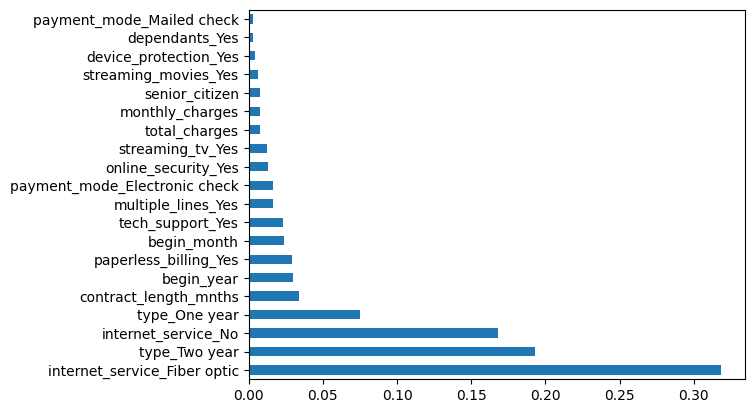

In [553]:
model = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.08,
              eval_metric=None, gamma=0.229, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.7159999999999994, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=710, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=189388003, reg_alpha=0)
model.fit(features_train, target_train)
print(model.feature_importances_)
# plot
feat_importances = pd.Series(model.feature_importances_, index=features_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

Самыми важными признаками, повлиявшими на уход клиента, модель XGBoost назвала вид соедниения интренета, вид контракта, и отутствие интернет-контракта 

Результаты модели мне кажутся неправдоподобными: не может быть, чтобы  результат предсказания логистической регрессией был идеальным.   
До того, как я добавила год начала и месяц начала контркта, ROC-AUC не превышал у меня 0.81  


<a id='Conclusion'></a>
### 7.  Выводы


1. Провели обучение, настройку и проверку модели классификации для определения пользователей, которые готовы разорвать контркт с телекоммуникационной компанией  
2. Лучшей моделью по метрике `ROC-AUC` является `LogisticRegression`, roc-auc достигла на тестовой выборке `1`, accuracy и f1 мера также лушчие у этой модели   
